In [ ]:
from tensorflow import keras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime



In [ ]:
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
data = yf.download("MSFT", start ="2004-01-01", end= "2025-06-30", interval="1d")
data.columns = ['_'.join(col).strip() for col in data.columns.values]

/tmp/ipython-input-2-191016579.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("MSFT", start ="2004-01-01", end= "2025-06-30", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [ ]:
data['log_return']= np.log(data['Close_MSFT']/data['Close_MSFT'].shift(1))
data['seven_day_moving_average'] = data['Close_MSFT'].rolling(window=7).mean()
print(data.head())
print(data.info())
print(data.describe())

            Close_MSFT  High_MSFT   Low_MSFT  Open_MSFT  Volume_MSFT  \
Date                                                                   
2004-01-02   16.975805  17.173702  16.901594  17.056200     44487700   
2004-01-05   17.402527  17.427264  17.142788  17.148972     67333700   
2004-01-06   17.464365  17.489103  17.359232  17.433444     46950800   
2004-01-07   17.445812  17.507655  17.322128  17.421076     54298200   
2004-01-08   17.414888  17.612785  17.315940  17.557126     58810800   

            log_return  seven_day_moving_average  
Date                                              
2004-01-02         NaN                       NaN  
2004-01-05    0.024826                       NaN  
2004-01-06    0.003547                       NaN  
2004-01-07   -0.001063                       NaN  
2004-01-08   -0.001774                       NaN  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5406 entries, 2004-01-02 to 2025-06-27
Data columns (total 7 columns):
 #   Column   

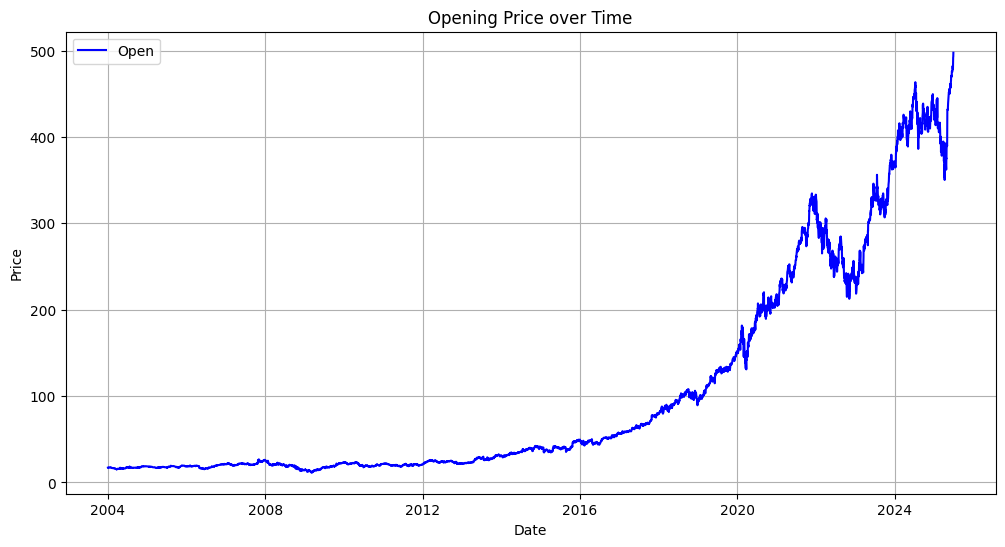

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Open_MSFT'], label="Open", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Opening Price over Time")
plt.legend()
plt.grid(True)
plt.show()

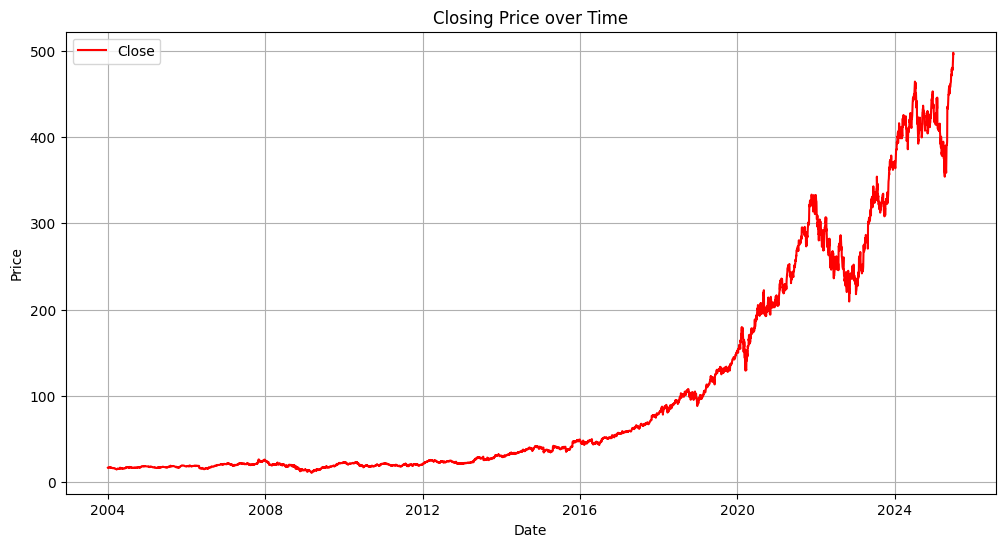

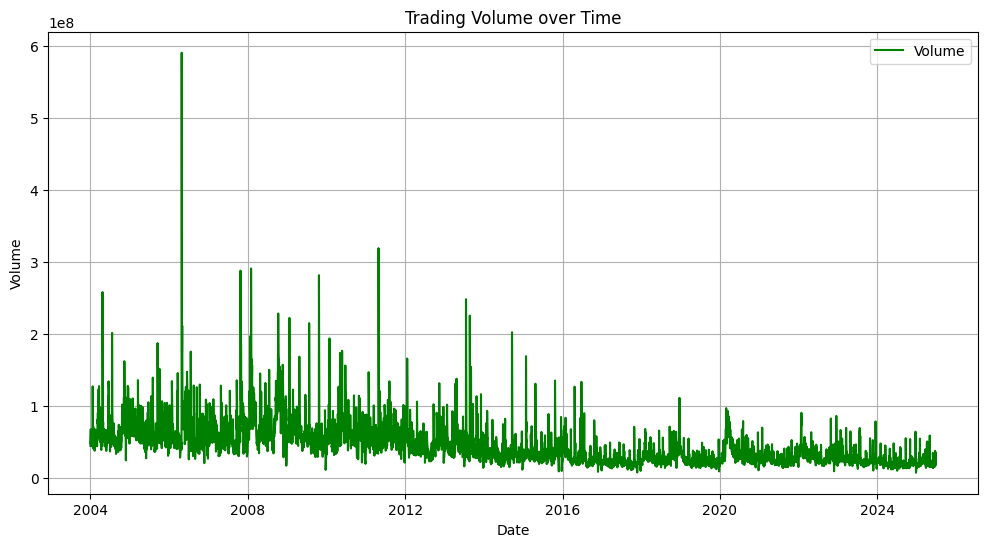

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close_MSFT'], label="Close", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Closing Price over Time")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Volume_MSFT'], label="Volume", color="green")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Trading Volume over Time")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
stock_close = data.Close_MSFT
dataset = stock_close.values
training_data_len = int(np.ceil(len(dataset) * 0.95))

print(training_data_len)

5136


In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))

training_data = scaled_data[:training_data_len]

x_train, y_train = [],[]

In [ ]:
for i in range(60, len(training_data)):
    x_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

In [ ]:
x_train, ytrain = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [ ]:
model_lstm = keras.models.Sequential()

#layers
#1st layer - LSTM 1
model_lstm.add(keras.layers.LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))

#drop 0.3
model_lstm.add(keras.layers.Dropout(0.1))

#2nd layer - LSTM 2
model_lstm.add(keras.layers.LSTM(units=128, return_sequences=False))

#drop 0.3
model_lstm.add(keras.layers.Dropout(0.1))

#3rd layer - Dense
model_lstm.add(keras.layers.Dense(256, activation="relu"))

#4th layer -Dense
model_lstm.add(keras.layers.Dense(units=1))

model_lstm.summary()

model_lstm.compile(optimizer="adam", loss="mae",metrics=[keras.metrics.RootMeanSquaredError()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,425 (904.00 KB)

 Trainable params: 231,425 (904.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
training = model_lstm.fit(x_train, ytrain, epochs=20, batch_size= 32)

#preparing the data
test_data= scaled_data[training_data_len - 60:]

x_test = []
y_test = dataset[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1165 - root_mean_squared_error: 0.2093
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0375 - root_mean_squared_error: 0.0596
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0372 - root_mean_squared_error: 0.0563
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0362 - root_mean_squared_error: 0.0582
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0297 - root_mean_squared_error: 0.0465
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0300 - root_mean_squared_error: 0.0486
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0329 - root_mean_squared_error: 0.0488
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0327 - root_mean_squared_error: 0.0491
Epoch 9/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0273 - root_mean_squared_error: 0.0477
Epoch 10/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0325 - root_mean_squared_e

In [ ]:
predictions = model_lstm.predict(x_test)
predictions = scaler.inverse_transform(predictions)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
train = data[:training_data_len]
test = data[training_data_len:]

test = test.copy()
test['Predictions'] = predictions

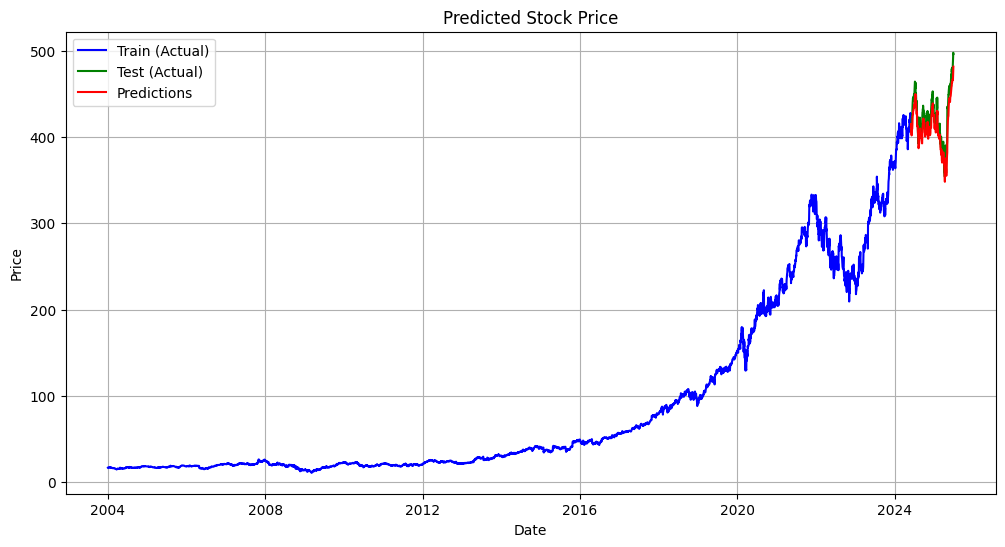

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Close_MSFT'], label="Train (Actual)", color="blue")
plt.plot(test.index, test['Close_MSFT'], label="Test (Actual)", color="green")
plt.plot(test.index, test['Predictions'], label="Predictions", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Predicted Stock Price")
plt.legend()
plt.grid(True)
plt.show()

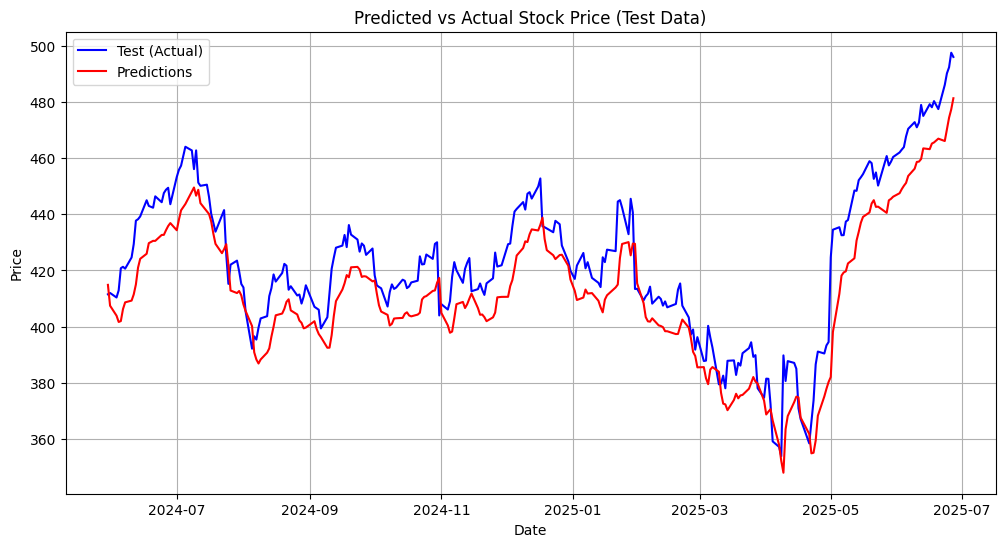

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(test.index, test['Close_MSFT'], label="Test (Actual)", color="blue")
plt.plot(test.index, test['Predictions'], label="Predictions", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Predicted vs Actual Stock Price (Test Data)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:



def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test['Close_MSFT'], test['Predictions'])
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 2.83%


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE for LSTM
rmse_lstm = sqrt(mean_squared_error(test['Close_MSFT'], test['Predictions']))
print(f"LSTM Root Mean Squared Error (RMSE): {rmse_lstm:.2f}")


LSTM Root Mean Squared Error (RMSE): 13.64


Random Forest Regressor model.

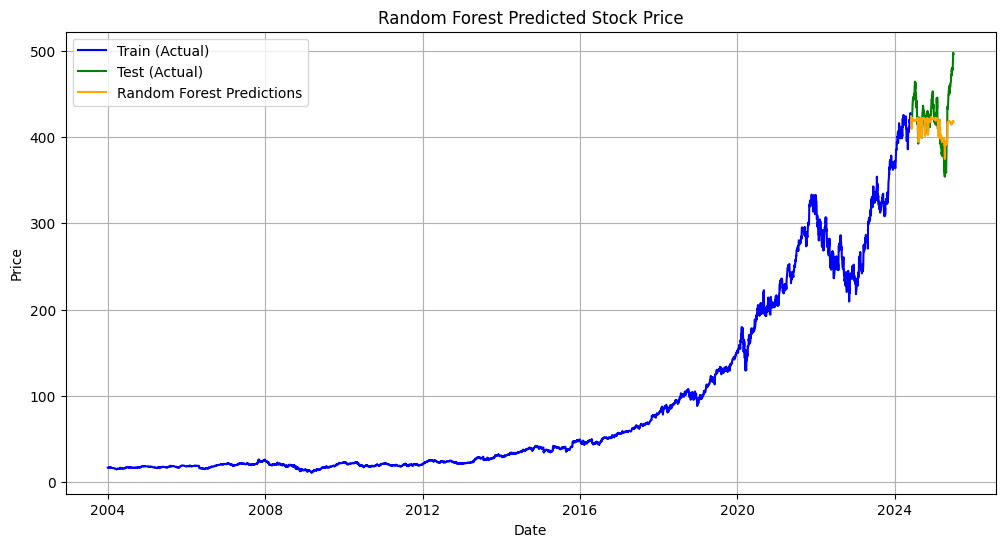

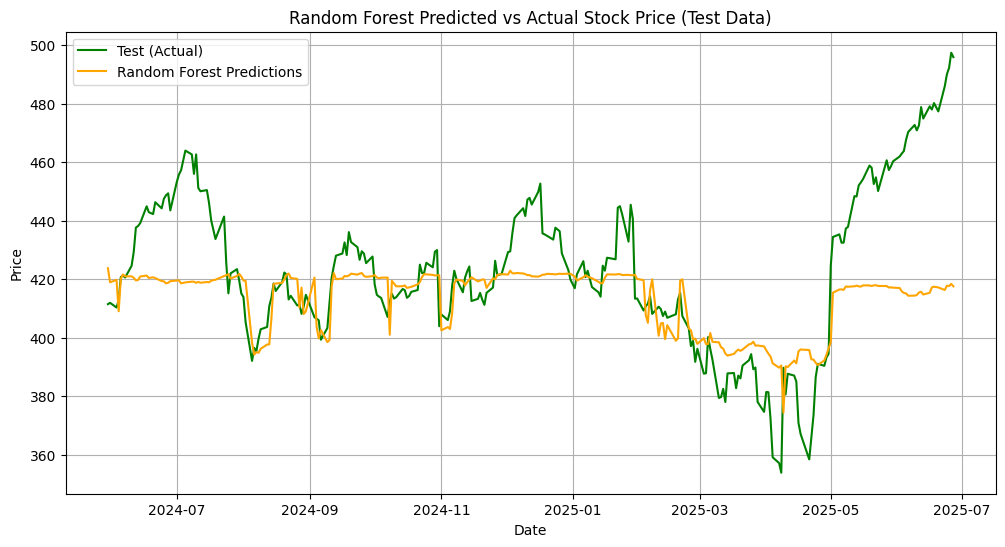

Random Forest Mean Absolute Percentage Error (MAPE): 3.66%
Random Forest Root Mean Squared Error (RMSE): 23.25


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Prepare data for Random Forest
# We will use the same training and test sets as for the LSTM model,
# but the input shape for Random Forest is 2D.
# We can use the 'x_train' and 'x_test' data but reshape them.

x_train_rf = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
x_test_rf = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train_rf, ytrain)

# Make predictions with the Random Forest model
rf_predictions_scaled = rf_model.predict(x_test_rf)

# Inverse transform the predictions to the original scale
rf_predictions = scaler.inverse_transform(rf_predictions_scaled.reshape(-1, 1)).flatten()

# Add the Random Forest predictions to a new dataframe for plotting and evaluation
test_rf = test.copy()
test_rf['RF_Predictions'] = rf_predictions

# Plotting the Random Forest predictions
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Close_MSFT'], label="Train (Actual)", color="blue")
plt.plot(test_rf.index, test_rf['Close_MSFT'], label="Test (Actual)", color="green")
plt.plot(test_rf.index, test_rf['RF_Predictions'], label="Random Forest Predictions", color="orange")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Random Forest Predicted Stock Price")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_rf.index, test_rf['Close_MSFT'], label="Test (Actual)", color="green")
plt.plot(test_rf.index, test_rf['RF_Predictions'], label="Random Forest Predictions", color="orange")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Random Forest Predicted vs Actual Stock Price (Test Data)")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the Random Forest model
rf_mape = mean_absolute_percentage_error(test_rf['Close_MSFT'], test_rf['RF_Predictions'])
print(f"Random Forest Mean Absolute Percentage Error (MAPE): {rf_mape:.2f}%")

rf_rmse = sqrt(mean_squared_error(test_rf['Close_MSFT'], test_rf['RF_Predictions']))
print(f"Random Forest Root Mean Squared Error (RMSE): {rf_rmse:.2f}")

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error

best_rmse = float("inf")
best_model = None
num_iterations = 10
rmse_list = []
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))
# Function to create a fresh LSTM model
def create_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
    model_lstm.add(keras.layers.Dropout(0.01))
    model.add(LSTM(50, return_sequences=False))
    model_lstm.add(keras.layers.Dropout(0.01))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Loop through model training
for p in range(num_iterations):
    model_lstm = create_model()  # Reinitialize model each time

    training = model_lstm.fit(x_train, ytrain, epochs=20, batch_size=32, verbose=0)

    test_data = scaled_data[training_data_len - 60:]
    x_test = []
    y_test = dataset[training_data_len:]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model_lstm.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    train = data[:training_data_len]
    test = data[training_data_len:].copy()
    test['Predictions'] = predictions
    rmse = RMSE(test['Close_MSFT'], test['Predictions'])
    rmse_list.append(rmse)

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model_lstm
        best_model.save('best_model.keras')  # Save best model
        print("New Best Model")
        print(f"New Best RMSE: {rmse:.6f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
New Best Model
New Best RMSE: 8.441788


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
New Best Model
New Best RMSE: 7.379450


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
New Best Model
New Best RMSE: 7.038890


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [ ]:
best_model = load_model("best_model.keras")

predictions = best_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
train = data[:training_data_len]
test = data[training_data_len:]

test = test.copy()
test['Predictions'] = predictions
mape = mean_absolute_percentage_error(test['Close_MSFT'], test['Predictions'])
rm = RMSE(test['Close_MSFT'], test['Predictions'])
print(f"best MAPE: {mape:.2f}%")
print(f"best rmse{rm:.6f}")



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
best MAPE: 0.01%
best rmse6.923545


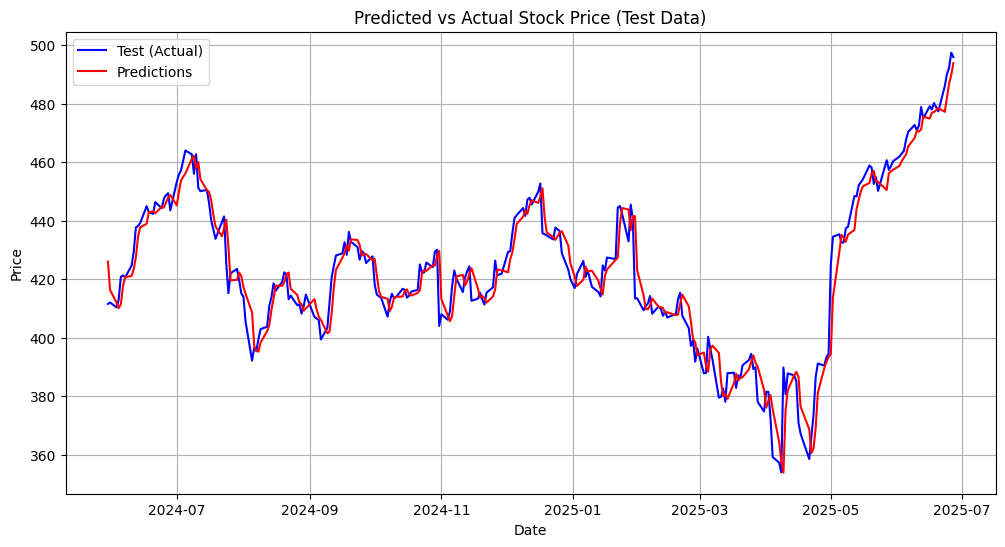

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(test.index, test['Close_MSFT'], label="Test (Actual)", color="blue")
plt.plot(test.index, test['Predictions'], label="Predictions", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Predicted vs Actual Stock Price (Test Data)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(test['Close_MSFT'], test['Predictions'])
print(f"Mean Absolute Percentage Error (MAPE): {mape:.6f}%")

Mean Absolute Percentage Error (MAPE): 0.012801%


In [ ]:

rmse = RMSE(test['Close_MSFT'], test['Predictions'])
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

Root Mean Squared Error (RMSE): 7.374890


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(test['Close_MSFT'], test['Predictions'])
print(f"R² Score: {r2:.4f}")


R² Score: 0.9241


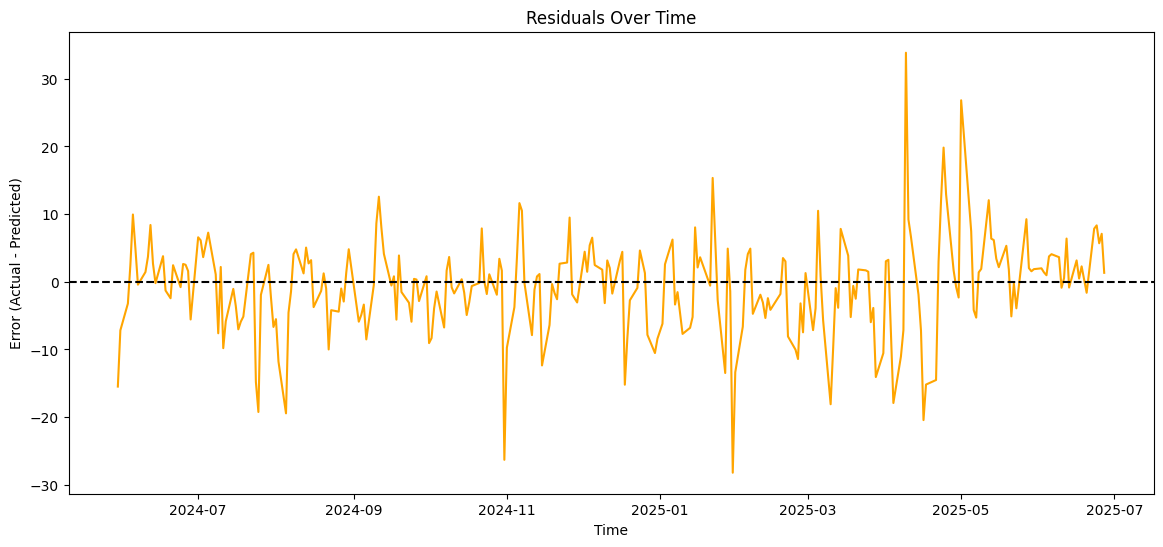

In [ ]:
# Residuals = Actual - Predicted
residuals = test['Close_MSFT'] - test['Predictions']
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(residuals, color='orange')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Error (Actual - Predicted)')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


In [ ]:
mean_rmse = np.mean(rmse_list)
print(f"Mean RMSE over {num_iterations} iterations: {mean_rmse:.6f}")


Mean RMSE over 10 iterations: 8.296187
